In [210]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,KFold
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,recall_score,precision_score,roc_curve,roc_auc_score

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [211]:
df= pd.read_csv('Churn3_AFTERSCALE.csv')
df.drop('c_State',axis=1,inplace=True) #Dropping state column as it is of least contribution to the model performance

In [265]:
df.head()

,c_AreaCode,c_InternationalPlan,c_VMailPlan,q_AccountLength,q_CustServCalls,q_DayCalls,q_DayCharge,q_DayMins,q_EveCalls,q_EveCharge,q_EveMins,q_InternationalCharge,q_InternationalMins,q_Internationalcalls,q_NightCalls,q_NightCharge,q_NightMins,q_VMailMessage,y_Churn
0,1,0,1,0.690901,-0.433885,0.500261,45.07,1.568293,-0.059527,16.78,-0.059921,2.70,-0.101301,-0.583487,-0.448712,11.01,0.872135,1.261885,0
1,1,0,1,0.160503,-0.433885,1.154156,27.47,-0.349166,0.142298,16.62,-0.097506,3.70,1.240707,-0.583487,0.153308,11.45,1.064069,1.335463,0
2,1,0,0,0.918214,-1.199068,0.701460,41.38,1.166275,0.495492,10.30,-1.567294,3.29,0.696649,0.230398,0.203477,7.32,-0.752381,-0.577587,0
3,0,1,0,-0.420409,0.331298,-1.461423,50.90,2.203741,-0.614545,5.26,-2.740354,1.78,-1.334498,1.044284,-0.549048,8.86,-0.073686,-0.577587,0
4,1,1,0,-0.647723,1.096480,0.651160,28.34,-0.254682,1.100966,12.61,-1.031207,2.73,-0.065031,-0.583487,1.056338,8.41,-0.271556,-0.577587,0


In [266]:
df.c_AreaCode.value_counts()

1    2299
0    1161
2    1157
Name: c_AreaCode, dtype: int64

In [213]:
X = df.drop('y_Churn',axis=1)
y=df.y_Churn

In [214]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [215]:
print(X_train.shape)
print(X_test.shape)
print(Counter(y_train))
print(Counter(y_test))

(3231, 18)
(1386, 18)
Counter({0: 2771, 1: 460})
Counter({0: 1190, 1: 196})


In [216]:
sm = SMOTE(random_state=10)
X_train_sm,y_train_sm = sm.fit_sample(X_train,y_train)

In [217]:
# now the chuners and non chuners ratio is same in the output
print(Counter(y_train_sm))
print(Counter(y_test))

Counter({0: 2771, 1: 2771})
Counter({0: 1190, 1: 196})


## Modeling with Random Forest using optimized hyperparameters from grid search

In [239]:
model = RandomForestClassifier(n_estimators=9,
 max_features='auto',
 criterion='entropy',
 bootstrap=False,random_state=10)

model.fit(X_train_sm,y_train_sm)


RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=9, n_jobs=None, oob_score=False, random_state=10,
            verbose=0, warm_start=False)

In [240]:
y_pred_rf= model.predict(X_test)

In [241]:
print(classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1190
           1       0.88      0.81      0.84       196

   micro avg       0.96      0.96      0.96      1386
   macro avg       0.93      0.89      0.91      1386
weighted avg       0.96      0.96      0.96      1386



In [242]:
# got a recall of 82% and precison of 80% at a particular trial
print("The recall is: {} %".format(recall_score(y_test,y_pred_rf).round(4)*100))
print("The Precision is: {} %".format(precision_score(y_test,y_pred_rf).round(3)*100))
print("The Accuracy is: {} %".format(accuracy_score(y_test,y_pred_rf).round(5)*100))

The recall is: 80.61 %
The Precision is: 88.3 %
The Accuracy is: 95.743 %


In [243]:
confusion_matrix(y_test,y_pred_rf)

array([[1169,   21],
       [  38,  158]])

In [244]:
print(y_test.shape)
print(y_pred_rf.shape)

(1386,)
(1386,)


## Grid Search Method
#### Grid-search is used to find the optimal hyperparameters of the model which results in the most ‘accurate’ predictions.

In [245]:
params= {'n_estimators':np.arange(1,10),
         'criterion': ['entropy','gini'],
          'max_features':['auto','sqrt','log2'],
         'bootstrap':[True,False]
          }

In [246]:
model1=RandomForestClassifier(random_state=21)
model_cv=RandomizedSearchCV(model1,params,cv=KFold(n_splits=5, random_state=10))
#model_cv =GridSearchCV(RandomForestClassifier(),params)

In [247]:
model_cv.fit(X_train_sm,y_train_sm)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=10, shuffle=False),
          error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=21, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': array([1, 2, 3, 4, 5, 6, 7, 8, 9]), 'criterion': ['entropy', 'gini'], 'max_features': ['auto', 'sqrt', 'log2'], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [248]:
model_cv.best_params_

{'n_estimators': 9,
 'max_features': 'auto',
 'criterion': 'entropy',
 'bootstrap': False}

In [249]:
model_cv.best_estimator_

RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=9, n_jobs=None, oob_score=False, random_state=21,
            verbose=0, warm_start=False)

In [250]:
model_cv.best_score_

0.9644532659689643

#### Using Grid search optimization technique and tuning the model with hyperparmeters
#### Recall increased from 77% to 81% , Precision from 86% to 88%


## ROC CURVE

In [251]:
#checking for the ROC - CHECK FOR EFFICIENCY OF THE MODEL
model.predict_proba(X_test)

array([[0.88888889, 0.11111111],
       [1.        , 0.        ],
       [1.        , 0.        ],
       ...,
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.77777778, 0.22222222]])

In [252]:
#EXTRACTING ONLY the 2nd column values as it the predict proba values for the churners
y_pred_prob=model.predict_proba(X_test)[:,1]
print(y_pred_prob)

[0.11111111 0.         0.         ... 0.         0.         0.22222222]


In [253]:
fpr, tpr , thresholds = roc_curve(y_test,y_pred_prob)

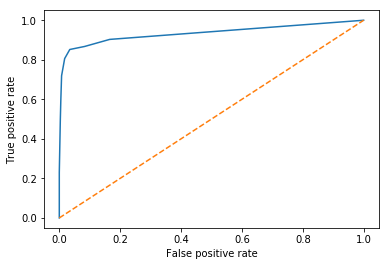

In [254]:
plt.plot(fpr,tpr)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.plot([0,1],[0,1],"--")
plt.show()

In [255]:
## The default probabilty threshold is 50% 

In [256]:
# checking the area under the curve - for a default random model AUC - 0.5 
#So, we make sure we get better AUC score for a better performing model

In [257]:
auc = roc_auc_score(y_test,y_pred_prob).round(3)*100

In [258]:
print(auc)

93.4


### From the above result we can see the area under the curve is 93% which indicates the model is pretty good for the predictions further

In [259]:
#importances= model.feature_importances_
#sort=np.argsort(importances)
#label=X.columns[sort]


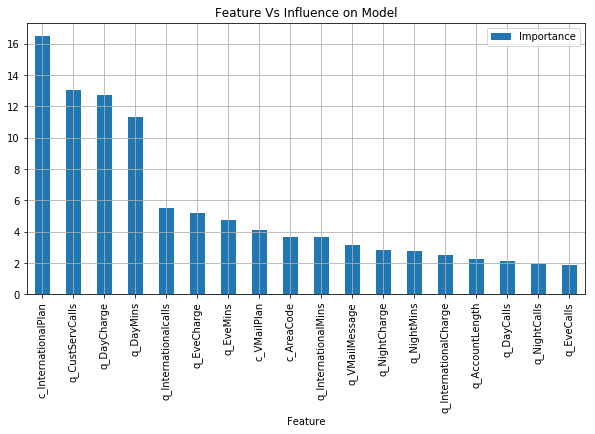

In [260]:
FeatureImp = pd.DataFrame({'Feature':X.columns,'Importance':model.feature_importances_*100})
FeatureImportance = FeatureImp.sort_values(by='Importance', axis=0, ascending=False)
FeatureImportance.plot(x='Feature',y='Importance',kind='bar',grid=True,title="Feature Vs Influence on Model",
            legend = True,figsize = (10,5),)

### The above figure shows the feature importances for the particular model and which features drive churn the most

In [261]:
from sklearn.externals import joblib

In [262]:
#Saving the entire model into a file
joblib.dump(model,'Telecom_Churn_Trained_Model.ml')

['Telecom_Churn_Trained_Model.ml']